# LAB: Regresión Logística: Haciendo predicciones sobre datos de cáncer de mama

## 1. Introducción

Este dataset sobre cáncer de mama se obtuvo del Hospital de la Universidad de Wisconsin. Son datos producidos por el Dr. William Wolberg en la década del '90. Contiene información de estudios clínicos y celulares. El objetivo es predecir el carácter benigno ($class_t=0$) maligno ($class_t=1$) del cáncer en función de una serie de predictores a nivel celular.


* class_t es la variable target

* el resto son variables con valores normalizados de 1 a 10


[Aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names) pueden encontrar más información sobre el dataset.

**Nota:** se eliminaron del dataset original 16 casos con valores perdidos en algunos campos.

In [1]:
### Importar los paquetes a usar
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

In [2]:
### Importamos los datos

df = pd.read_csv('../Data/breast-cancer.csv', header = None)
df.columns = ['ID', 'clump_Thickness', 'unif_cell_size', 'unif_cell_shape', 'adhesion', 'epith_cell_Size', 'bare_nuclei',
              'bland_chromatin ','norm_nucleoli', 'mitoses', 'class_t']
df.sample(10)

,ID,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
214,1224329,1,1,1,2,2,1,3,1,1,2
421,1295186,10,10,10,1,6,1,2,8,1,4
379,1158247,1,1,1,1,1,1,1,1,1,2
243,191250,10,4,4,10,2,10,5,3,3,4
443,1266124,5,1,2,1,2,1,1,1,1,2
574,1272166,5,1,1,1,2,1,1,1,1,2
148,1189286,10,10,8,6,4,5,8,10,1,4
488,1265899,4,1,1,1,2,1,3,1,1,2
441,1257470,10,6,5,8,5,10,8,6,1,4
341,857774,4,1,1,1,3,1,2,2,1,2


In [3]:
df.class_t[df['class_t'] == 2] = 0
df.class_t[df['class_t'] == 4] = 1

## 2. Análisis Exploratorio de los Datos

Realizar un análisis descriptivo y exploratorio de los datos.

In [4]:
df.iloc[:,1:len(df)].describe()

,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


¿Qué variables están más correlacionadas entre sí y con la variable dependiente?

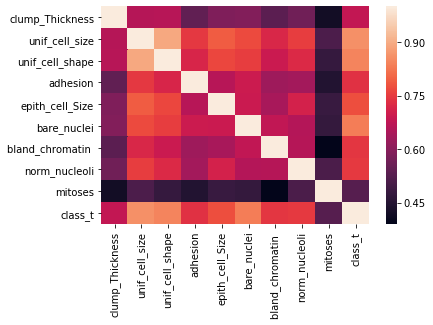

In [5]:
sns.heatmap(df.corr(method = 'spearman').iloc[1:len(df),1:len(df)]);

## 3. Fiteando un modelo de regresión logística

Dividimos el target y la matriz de features

In [6]:
X = df.iloc[:,1:9]

In [7]:
y = df['class_t']

Vamos a dividir el dataset en set de entrenamiento y de testeo. 

Vamos a entrenar el modelo en el set de entrenamiento, aplicando validación cruzada para definir el mejor valor del parámetro de regularización C. Pueden aplicar también diferentes técnicas de regularización.

**Hint:** traten de usar el iterador [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) del módulo `sklearn.model_selection`.

- Lo que devuelve el método `KFold` es un array de índices con las $k$ particiones entre train y test.

- Luego, pueden usar esos índices para hacer subsetting del dataframe

##### Train-Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

In [9]:
# Utilizamos sklearn para estandarizar la matriz de Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [10]:
# Vamos a querer graficar los distintos valores del score de cross validation en función del hiperparámetro C
# Para esto generamos una lista de diccionarios que después se puede convertir fácilmente en DataFrame

lg_scores_para_df = []

# Probamos algunos valores de C 

C_lista = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


for i in C_lista:
    
    # En cada iteración instanciamos el modelo con un hiperparámetro distinto
    model = linear_model.LogisticRegression(C=i, solver='liblinear')
    
    # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
    dict_row_score = {'score_medio':np.mean(cv_scores), 'score_std':np.std(cv_scores), 'C':i}
    
    # Guardo cada uno en la lista de diccionarios
    lg_scores_para_df.append(dict_row_score)

In [11]:
# Creamos el DataFrame a partir de la lista de diccionarios
lg_df_scores = pd.DataFrame(lg_scores_para_df)
lg_df_scores

,C,score_medio,score_std
0,0.0001,0.970720,0.019497
1,0.0010,0.970720,0.019497
2,0.0100,0.970720,0.019497
3,0.1000,0.972662,0.020821
4,1.0000,0.962876,0.024304
5,10.0000,0.960896,0.024115
6,100.0000,0.960896,0.024115
7,1000.0000,0.958935,0.021061
8,10000.0000,0.958935,0.021061


In [12]:
lg_df_scores['limite_inferior'] = lg_df_scores['score_medio'] - lg_df_scores['score_std']
lg_df_scores['limite_superior'] = lg_df_scores['score_medio'] + lg_df_scores['score_std']
lg_df_scores.head()

,C,score_medio,score_std,limite_inferior,limite_superior
0,0.0001,0.970720,0.019497,0.951223,0.990217
1,0.0010,0.970720,0.019497,0.951223,0.990217
2,0.0100,0.970720,0.019497,0.951223,0.990217
3,0.1000,0.972662,0.020821,0.951841,0.993482
4,1.0000,0.962876,0.024304,0.938572,0.987181


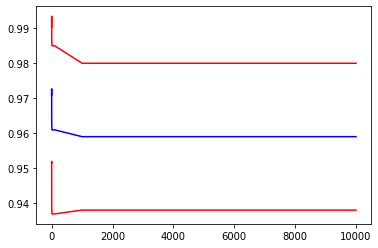

In [13]:
plt.plot(lg_df_scores['C'],lg_df_scores['limite_inferior'],color='r')
plt.plot(lg_df_scores['C'],lg_df_scores['score_medio'],color='b')
plt.plot(lg_df_scores['C'],lg_df_scores['limite_superior'],color='r');

* ¿Cuál es la performance de este modelo? ¿Cuáles son los mejores hiperparámetros?

In [14]:
lg_df_scores.loc[lg_df_scores.score_medio == lg_df_scores.score_medio.max()]

,C,score_medio,score_std,limite_inferior,limite_superior
3,0.1,0.972662,0.020821,0.951841,0.993482


##### Entrenamos de nuevo el modelo con todo es set de entrenamiento utilizando el hiperparámetro óptimo:

In [15]:
lg_modelo_optimizado = linear_model.LogisticRegression(C=0.1, solver='liblinear')

lg_modelo_optimizado.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
X_test_scaled = scaler.transform(X_test)

y_pred_lg_test = lg_modelo_optimizado.predict(X_test_scaled)

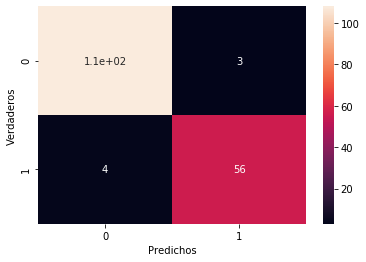

In [17]:
# Elaboramos la matriz de confusión:

confusion_matrix(y_test, y_pred_lg_test)

sns.heatmap(confusion_matrix(y_test, y_pred_lg_test), annot=True)


plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

In [18]:
# Calculamos el accuracy

accuracy_score(y_test, y_pred_lg_test)

0.9590643274853801

## 4. Comparación con KNN

Con el mismo split entre train y test que generaron anteriormente, utilizar el conjunto de train para estimar un modelo de KNN con hiperparámetros óptimos y comparar la performance sobre datos no observados con respecto a la regresión logística. 

In [19]:
# Vamos a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
# Para esto generamos una lista de diccionarios que después se puede convertir fácilmente en DataFrame

# Probamos todos los enteros desde el 1 hasta el 10 como posibles valores de n_neighbors aexplorar

knn_scores_para_df = []

for i in range(1, 11):
    
    # En cada iteración instanciamos el modelo con un hiperparámetro distinto
    model = KNeighborsClassifier(n_neighbors=i)
    
    # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
    dict_row_score = {'score_medio':np.mean(cv_scores), 'score_std':np.std(cv_scores), 'n_neighbours':i}
    
    # Guardo cada uno en la lista de diccionarios
    knn_scores_para_df.append(dict_row_score)

In [20]:
# Creamos el DataFrame a partir de la lista de diccionarios
knn_df_scores = pd.DataFrame(knn_scores_para_df)
knn_df_scores.head()

,n_neighbours,score_medio,score_std
0,1,0.962915,0.012824
1,2,0.951169,0.010642
2,3,0.960935,0.017436
3,4,0.960954,0.016331
4,5,0.966817,0.016957


In [21]:
knn_df_scores['limite_inferior'] = knn_df_scores['score_medio'] - knn_df_scores['score_std']
knn_df_scores['limite_superior'] = knn_df_scores['score_medio'] + knn_df_scores['score_std']
knn_df_scores.head()

,n_neighbours,score_medio,score_std,limite_inferior,limite_superior
0,1,0.962915,0.012824,0.950091,0.975739
1,2,0.951169,0.010642,0.940527,0.961811
2,3,0.960935,0.017436,0.943498,0.978371
3,4,0.960954,0.016331,0.944623,0.977284
4,5,0.966817,0.016957,0.949860,0.983775


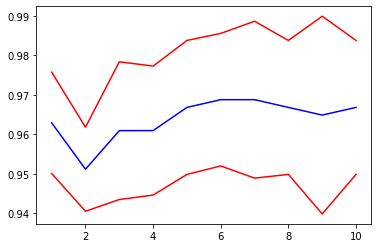

In [22]:
plt.plot(knn_df_scores['n_neighbours'],knn_df_scores['limite_inferior'],color='r')
plt.plot(knn_df_scores['n_neighbours'],knn_df_scores['score_medio'],color='b')
plt.plot(knn_df_scores['n_neighbours'],knn_df_scores['limite_superior'],color='r');

In [23]:
knn_df_scores.loc[knn_df_scores.score_medio == knn_df_scores.score_medio.max()]

,n_neighbours,score_medio,score_std,limite_inferior,limite_superior
5,6,0.968778,0.016778,0.952001,0.985556
6,7,0.968778,0.019865,0.948914,0.988643


##### Entrenamos de nuevo el modelo con todo es set de entrenamiento utilizando el hiperparámetro óptimo:

In [24]:
knn_modelo_optimizado = KNeighborsClassifier(n_neighbors=6)

knn_modelo_optimizado.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [25]:
y_pred_knn_test = knn_modelo_optimizado.predict(X_test_scaled)

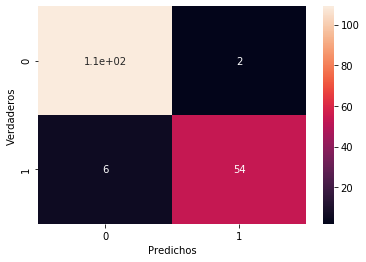

In [26]:
# Elaboramos la matriz de confusión:

confusion_matrix(y_test, y_pred_knn_test)

sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True)


plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

In [27]:
# Calculamos el accuracy

accuracy_score(y_test, y_pred_knn_test)

0.9532163742690059